In [16]:
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import qr
import numpy.linalg as npla
import scipy as sp
from scipy.linalg import block_diag, logm, eigvals
from multiprocessing import Pool
from functools import partial
import multiprocessing as mp
from multiprocessing import set_start_method
from multiprocessing import get_context
import joblib
import matplotlib.pyplot as plt
import time
from scipy.linalg import lu

In [17]:
def TAMatrix(sin,cos):
    
    phases = (2*np.pi)*np.random.random_sample(3)
    
    matrix_one = np.array([[1,0],[0,np.exp(-1j*phases[0])]])
    matrix_two = np.array([[1,-sin],[-sin,1]])
    matrix_three = np.array([[np.exp(1j*phases[1]),0],[0,np.exp(-1j*phases[2])]])

    return (1/cos)*multi_dot([matrix_one,matrix_two,matrix_three])
            
def TBMatrix(sin,cos):   
    
    phases = (2*np.pi)*np.random.random_sample(3)
    
    matrix_one = np.array([[np.exp(-1j*phases[1]),0],[0,np.exp(1j*phases[0])]])
    matrix_two = np.array([[1,cos],[cos,1]])
    matrix_three = np.array([[-1,0],[0,np.exp(1j*phases[2])]])

    return (1/sin*multi_dot([matrix_one,matrix_two,matrix_three]))

def TAReplace(sin,cos):
    TAmatricies = [TAMatrix(sin,cos) for i in range(4)]
    TBmatricies = TBMatrix(sin,cos)
    
    M = multi_dot([
            block_diag(TAmatricies[0],TAmatricies[1]),
            block_diag(1,TBmatricies,1),
            block_diag(TAmatricies[2],TAmatricies[3])
    ])

    new_TA = np.zeros((2,2), dtype = 'complex_')
    denominator = (M[2,1]+M[2,2]-M[1,1]-M[1,2])
    new_TA[0,0] = M[0,0] + (((M[0,1] + M[0,2])*(M[1,0]-M[2,0]))/denominator)
    new_TA[0,1] = M[0,3] + (((M[0,1] + M[0,2])*(M[1,3]-M[2,3]))/denominator)
    new_TA[1,0] = M[3,0] + (((M[3,1] + M[3,2])*(M[1,0]-M[2,0]))/denominator)
    new_TA[1,1] = M[3,3] + (((M[3,1] + M[3,2])*(M[1,3]-M[2,3]))/denominator)

    return new_TA

def TBReplace(sin,cos):
    TBmatricies = [TBMatrix(sin,cos) for i in range(4)]
    TAmatricies = TAMatrix(sin,cos)
    
    M = multi_dot([
            block_diag(TBmatricies[0],TBmatricies[1]),
            block_diag(1,TAmatricies,1),
            block_diag(TBmatricies[2],TBmatricies[3])
    ])

    new_TB = np.zeros((2,2), dtype = 'complex_')
    denominator = (M[2,1]+M[2,2]-M[1,1]-M[1,2])
    new_TB[0,0] = M[0,0] + (((M[0,1] + M[0,2])*(M[1,0]-M[2,0]))/denominator)
    new_TB[0,1] = M[0,3] + (((M[0,1] + M[0,2])*(M[1,3]-M[2,3]))/denominator)
    new_TB[1,0] = M[3,0] + (((M[3,1] + M[3,2])*(M[1,0]-M[2,0]))/denominator)
    new_TB[1,1] = M[3,3] + (((M[3,1] + M[3,2])*(M[1,3]-M[2,3]))/denominator)

    return new_TB
    


In [18]:
def FullStrip(sin,cos,strip_width,probability_cutoff):
        
        def TAS(sin,cos,strip_width,probability_cutoff):
            
            TAProbabilities = np.random.random_sample(strip_width)
            
            Tslist = [ 
                TAMatrix(sin,cos) if i < probability_cutoff 
                else TAReplace(sin,cos) for i in TAProbabilities
            ]
            
            return block_diag(*Tslist)

        
        def TBS(sin,cos,strip_width,probability_cutoff):
            
            TBProbabilities = np.random.random_sample(strip_width-1)
            
            Tslist = [ 
                TBMatrix(sin,cos)if i < probability_cutoff
                else TBReplace(sin,cos) for i in TBProbabilities
            ]
            
            extra = TBMatrix(sin,cos)
            temp_mat = block_diag(extra[1,1],*Tslist,extra[0,0])    
            temp_mat[0,(2*strip_width)-1] = extra[1,0]
            temp_mat[(2*strip_width)-1,0] = extra[0,1]
            return temp_mat
    
        return np.matmul(TAS(sin,cos,strip_width,probability_cutoff),
                         TBS(sin,cos,strip_width,probability_cutoff))



In [19]:
def FullTransfer(strip_length,strip_width,probability_cutoff, theta): 
    #Saving values of Sin and Cos
    sin = np.sin(theta)
    cos = np.cos(theta)
    
    #Group_val describes how often the LU is carried out
    group_val = 8
    
    #creating matricies
    matricies = [FullStrip(sin,cos,strip_width,probability_cutoff) for i in range(strip_length)]
    #splitting matricies
    
    every_nth = [multi_dot(matricies[i:i+group_val]) for i in range(int(strip_length/group_val))]
    
    Tone = matricies[0]
    qone,rone = qr(Tone)
    bigQ = qone
    rlog_one = np.log(np.absolute(rone.diagonal()))
    
    for i in every_nth:
        matrixb = np.matmul(i,bigQ)
        q,r = qr(matrixb)
        bigQ = q
        rlogs = np.log(np.absolute(r.diagonal()))
        rlog_one = np.add(rlogs,rlog_one)
    return rlog_one

In [20]:
strip_length = int(1000)
strip_width = int(16)
probability_cutoff = 1
theta_crit =np.pi/4
start_time = time.time()
theta_list = np.linspace(theta_crit,1.5,15)
partial_func = partial(FullTransfer,strip_length,strip_width,probability_cutoff)
p = get_context("fork").Pool()
final_array= p.map(partial_func, theta_list)
#final_array = np.concatenate(final_array[0]).ravel().tolist()
#joblib.dump(final_array, '113_width8_length1e6.pkl')
np.save('length1000_width8_Jan29th_pi4_probhalf.npy',final_array)
print("--- %s minutes---" % ((time.time() - start_time)/60))

--- 0.20614384810129802 minutes---


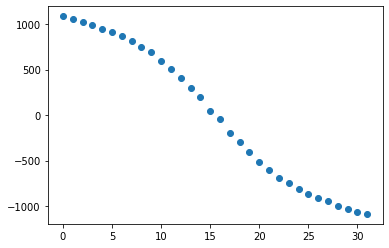

In [21]:
plt.scatter([i for i in range(strip_width * 2)],final_array[1])


In [22]:
sin = np.sin(np.pi/4)
cos = np.cos(np.pi/4)
abs(npla.det(TBReplace(sin,cos)))

0.9999999999999991